In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge datasets
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')
merged_df = merged_df.merge(products_df, on='ProductID', how='left')

print("Merged Dataset:")
print(merged_df.head())

Merged Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving B

In [11]:
# Feature Engineering
# 1. Customer Demographics
customer_features = customers_df[['CustomerID', 'Region', 'SignupDate']]

# 2. Transaction Behavior
transaction_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],  # Total spending and average transaction value
    'Category': lambda x: x.mode()[0] if not x.mode().empty else np.nan  # Most frequent product category
}).reset_index()
transaction_features.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'FavoriteCategory']

# Merge customer and transaction features
customer_profiles = customer_features.merge(transaction_features, on='CustomerID', how='left')

print("\nCustomer Profiles:")
print(customer_profiles.head())


Customer Profiles:
  CustomerID         Region  SignupDate  TotalSpending  AvgTransactionValue  \
0      C0001  South America  2022-07-10        3354.52              670.904   
1      C0002           Asia  2022-02-13        1862.74              465.685   
2      C0003  South America  2024-03-07        2725.38              681.345   
3      C0004  South America  2022-10-09        5354.88              669.360   
4      C0005           Asia  2022-08-15        2034.24              678.080   

  FavoriteCategory  
0      Electronics  
1         Clothing  
2       Home Decor  
3            Books  
4      Electronics  


In [12]:
# Handle missing values in 'FavoriteCategory'
customer_profiles['FavoriteCategory'] = customer_profiles['FavoriteCategory'].fillna('Unknown')

# Handle missing values in numerical features
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean value
customer_profiles[['TotalSpending', 'AvgTransactionValue']] = imputer.fit_transform(
    customer_profiles[['TotalSpending', 'AvgTransactionValue']]
)

print("\nCustomer Profiles After Handling Missing Values:")
print(customer_profiles.head())


Customer Profiles After Handling Missing Values:
  CustomerID         Region  SignupDate  TotalSpending  AvgTransactionValue  \
0      C0001  South America  2022-07-10        3354.52              670.904   
1      C0002           Asia  2022-02-13        1862.74              465.685   
2      C0003  South America  2024-03-07        2725.38              681.345   
3      C0004  South America  2022-10-09        5354.88              669.360   
4      C0005           Asia  2022-08-15        2034.24              678.080   

  FavoriteCategory  
0      Electronics  
1         Clothing  
2       Home Decor  
3            Books  
4      Electronics  


In [13]:
# Encode categorical variables
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_profiles[['Region']]).toarray()
encoded_category = encoder.fit_transform(customer_profiles[['FavoriteCategory']]).toarray()

# Combine encoded features with numerical features
numerical_features = customer_profiles[['TotalSpending', 'AvgTransactionValue']].values
features = np.hstack([encoded_region, encoded_category, numerical_features])

print("\nEncoded Features:")
print(features[:5])  # Print first 5 rows of encoded features


Encoded Features:
[[0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 3.35452e+03 6.70904e+02]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.86274e+03 4.65685e+02]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 2.72538e+03 6.81345e+02]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 5.35488e+03 6.69360e+02]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 2.03424e+03 6.78080e+02]]


In [14]:
# Normalize numerical features
scaler = StandardScaler()
features[:, -2:] = scaler.fit_transform(features[:, -2:])

print("\nNormalized Features:")
print(features[:5])  # Print first 5 rows of normalized features


Normalized Features:
[[ 0.          0.          0.          1.          0.          0.
   1.          0.          0.         -0.06185626 -0.07043973]
 [ 1.          0.          0.          0.          0.          1.
   0.          0.          0.         -0.87994615 -0.9372791 ]
 [ 0.          0.          0.          1.          0.          0.
   0.          1.          0.         -0.40687569 -0.02633724]
 [ 0.          0.          0.          1.          1.          0.
   0.          0.          0.          1.03513813 -0.07696154]
 [ 1.          0.          0.          0.          0.          0.
   1.          0.          0.         -0.78589581 -0.04012851]]


In [15]:
# Calculate similarity scores using Cosine Similarity
similarity_matrix = cosine_similarity(features)

print("\nSimilarity Matrix:")
print(similarity_matrix[:5, :5])  # Print a 5x5 subset of the similarity matrix


Similarity Matrix:
[[ 1.          0.04446658  0.49233384  0.37862457  0.45838381]
 [ 0.04446658  1.          0.13605301 -0.25015876  0.55902848]
 [ 0.49233384  0.13605301  1.          0.22496735  0.13468477]
 [ 0.37862457 -0.25015876  0.22496735  1.         -0.28544944]
 [ 0.45838381  0.55902848  0.13468477 -0.28544944  1.        ]]


In [16]:
# Create a dictionary to store lookalikes
lookalike_map = {}

# Get top 3 lookalikes for each customer (C0001 - C0020)
for i, customer_id in enumerate(customer_profiles['CustomerID'][:20]):
    similarity_scores = similarity_matrix[i]
    top_3_indices = np.argsort(similarity_scores)[-4:-1]  # Exclude self (highest similarity)
    top_3_customers = customer_profiles.iloc[top_3_indices]['CustomerID'].tolist()
    top_3_scores = similarity_scores[top_3_indices].tolist()
    lookalike_map[customer_id] = list(zip(top_3_customers, top_3_scores))

# Save results to Lookalike.csv
lookalike_df = pd.DataFrame(lookalike_map.items(), columns=['CustomerID', 'Lookalikes'])
lookalike_df.to_csv('Lookalike.csv', index=False)

print("\nLookalike Recommendations:")
print(lookalike_df.head())


Lookalike Recommendations:
  CustomerID                                         Lookalikes
0      C0001  [(C0048, 0.9407876759891012), (C0181, 0.949431...
1      C0002  [(C0106, 0.9219146345254724), (C0134, 0.967757...
2      C0003  [(C0031, 0.8829390327081897), (C0152, 0.969199...
3      C0004  [(C0169, 0.9457006040029727), (C0165, 0.953488...
4      C0005  [(C0007, 0.8741525682363964), (C0186, 0.972966...


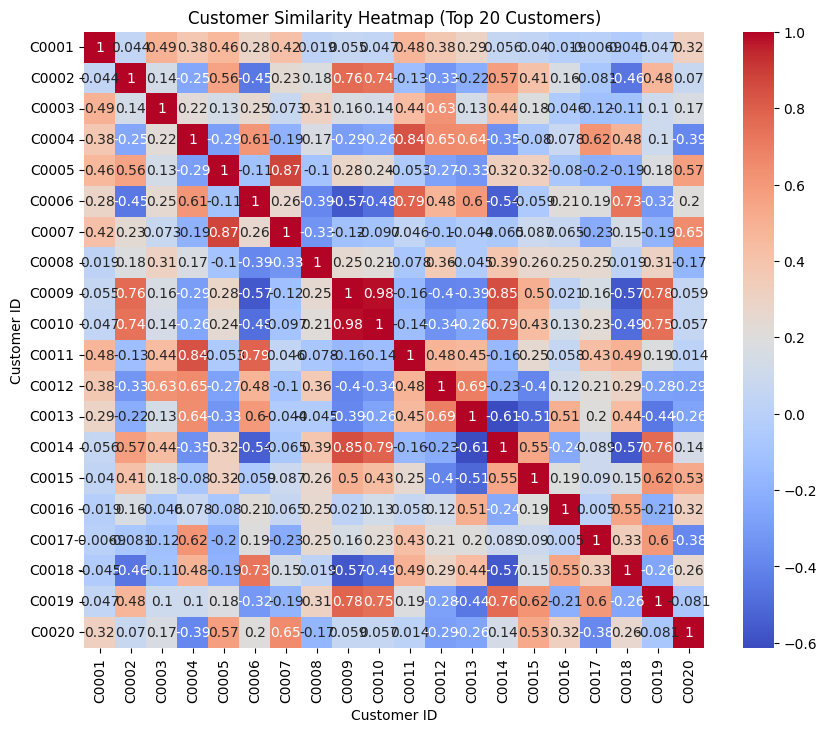

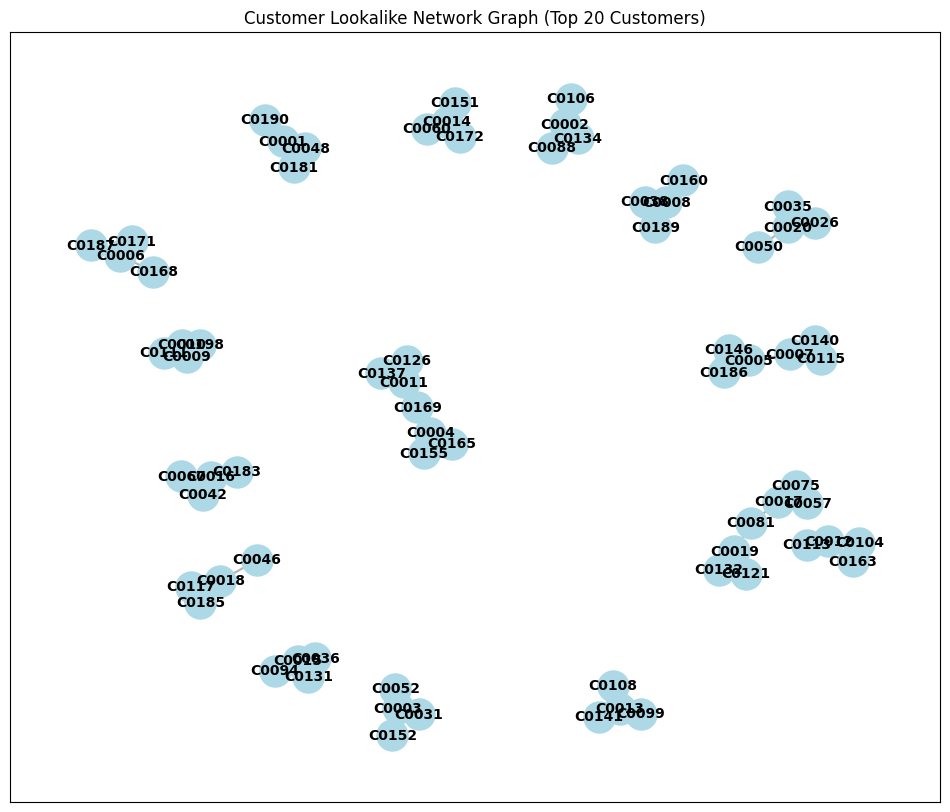

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# Visualizations

# 1. Heatmap of Similarity Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:20, :20], annot=True, cmap='coolwarm', xticklabels=customer_profiles['CustomerID'][:20], yticklabels=customer_profiles['CustomerID'][:20])
plt.title('Customer Similarity Heatmap (Top 20 Customers)')
plt.xlabel('Customer ID')
plt.ylabel('Customer ID')
plt.show()

# 2. Network Graph of Lookalikes
G = nx.Graph()

# Add nodes and edges for the top 20 customers and their lookalikes
for customer_id, lookalikes in lookalike_map.items():
    G.add_node(customer_id)
    for lookalike, score in lookalikes:
        G.add_edge(customer_id, lookalike, weight=score)

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent visualization
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title('Customer Lookalike Network Graph (Top 20 Customers)')
plt.show()